# Brain Tumor Detection


En los últimos años, ha crecido el interés sobre el uso de técnicas de machine learning para mejorar la precisión y eficiencia médica en el análisis de imágenes, especialmente en el área de detección de imágenes MRI. Los tumores cerebrales son difíciles de detectar usando métodos tradicionales, por ello los modelos de machine learning pueden ayudar a identificar patrones.

El uso de modelos de deep learning para la detección de tumores en MRI tienen un gran potencial. Estos modelos son entrenados con un dataset de imágenes previamente etiquetadas, una vez entrenados son capaces de predecir nuevas imágenes no etiquetadas.

## AUTORES: Antonio Gonzalez Suarez, Fernando Revuelta San Emeterio y Agustín Rodriguez Agudo

In [ ]:
# Imports

from google.colab import drive 

import os
import sys
import shutil
import hashlib
import collections

import matplotlib.pyplot as plt

import numpy as np
import math
import random
from skimage import io, filters
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from typing import Union

In [ ]:
# Mount drive

drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Colab Path set up Fer

os.chdir("/content/drive/My Drive") 
sys.path.append("/content/drive/My Drive/") 
    
# Root directory of the project 
ROOT_DIR = os.path.abspath(".") 

In [ ]:
# Set paths

base_dir = r'./brainTumorDetection'
data_dir = base_dir + r'/data'
train_dir = data_dir + r'/Training'
test_dir = data_dir + r'/Testing'

# Get Data

In [ ]:
!ls brainTumorDetection/data/

data1  data1.zip  data2  data2.zip  Testing  Training


In [ ]:
!rm -r brainTumorDetection/data/Training brainTumorDetection/data/Testing

In [ ]:
# Create final dirs
# Train
!mkdir brainTumorDetection/data/Training
!mkdir brainTumorDetection/data/Training/glioma_tumor
!mkdir brainTumorDetection/data/Training/meningioma_tumor
!mkdir brainTumorDetection/data/Training/pituitary_tumor
!mkdir brainTumorDetection/data/Training/no_tumor
# Test
!mkdir brainTumorDetection/data/Testing
!mkdir brainTumorDetection/data/Testing/glioma_tumor
!mkdir brainTumorDetection/data/Testing/meningioma_tumor
!mkdir brainTumorDetection/data/Testing/pituitary_tumor
!mkdir brainTumorDetection/data/Testing/no_tumor

# Unzip data
!unzip brainTumorDetection/data/data1.zip -d brainTumorDetection/data/data1
!unzip brainTumorDetection/data/data2.zip -d brainTumorDetection/data/data2

# Copy data1
# Train
!cp brainTumorDetection/data/data1/Training/glioma_tumor/* brainTumorDetection/data/Training/glioma_tumor
!cp brainTumorDetection/data/data1/Training/meningioma_tumor/* brainTumorDetection/data/Training/meningioma_tumor
!cp brainTumorDetection/data/data1/Training/pituitary_tumor/* brainTumorDetection/data/Training/pituitary_tumor
!cp brainTumorDetection/data/data1/Training/no_tumor/* brainTumorDetection/data/Training/no_tumor
# Test
!cp brainTumorDetection/data/data1/Testing/glioma_tumor/* brainTumorDetection/data/Training/glioma_tumor
!cp brainTumorDetection/data/data1/Testing/meningioma_tumor/* brainTumorDetection/data/Training/meningioma_tumor
!cp brainTumorDetection/data/data1/Testing/pituitary_tumor/* brainTumorDetection/data/Training/pituitary_tumor
!cp brainTumorDetection/data/data1/Testing/no_tumor/* brainTumorDetection/data/Training/no_tumor

# Copy data2
# Train
!cp brainTumorDetection/data/data2/Training/glioma/* brainTumorDetection/data/Training/glioma_tumor
!cp brainTumorDetection/data/data2/Training/meningioma/* brainTumorDetection/data/Training/meningioma_tumor
!cp brainTumorDetection/data/data2/Training/pituitary/* brainTumorDetection/data/Training/pituitary_tumor
!cp brainTumorDetection/data/data2/Training/notumor/* brainTumorDetection/data/Training/no_tumor
# Test
!cp brainTumorDetection/data/data2/Testing/glioma/* brainTumorDetection/data/Training/glioma_tumor
!cp brainTumorDetection/data/data2/Testing/meningioma/* brainTumorDetection/data/Training/meningioma_tumor
!cp brainTumorDetection/data/data2/Testing/pituitary/* brainTumorDetection/data/Training/pituitary_tumor
!cp brainTumorDetection/data/data2/Testing/notumor/* brainTumorDetection/data/Training/no_tumor

# Delete
!rm -r brainTumorDetection/data/data1
!rm -r brainTumorDetection/data/data2

In [ ]:
# Delete duplicate images
def hash_image(file_path: str)->str:
    """
    Returns the SHA-256 hash of an image file.
    :param file_path: Path to the image file
    :return: Hash of the image file
    """
    with open(file_path, 'rb') as f:
        return hashlib.sha256(f.read()).hexdigest()

def find_and_remove_duplicate_images(
    directory: str,
    return_file_name: bool = False
    )->Union[None,list[str]]:
    """
    Finds and removes duplicate images in the specified directory.
    :param directory: Directory to find duplicates
    :return: None, duplicated images are removed from directory. If
      return_file_name the it returns a list with the file names deleted
    """
    hash_values = []
    file_names = []
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if os.path.isfile(file_path):
            hash_value = hash_image(file_path)
            if hash_value in hash_values:
                os.remove(file_path)
                file_names.append(file_path.split("/")[-1])
            else:
              hash_values.append(hash_value)
    print(f"{len(file_names)} duplicates have been removed from {directory}")
    if return_file_name:
      return file_names


find_and_remove_duplicate_images('brainTumorDetection/data/Training/glioma_tumor/')
find_and_remove_duplicate_images('brainTumorDetection/data/Training/meningioma_tumor/')
find_and_remove_duplicate_images('brainTumorDetection/data/Training/pituitary_tumor/')
find_and_remove_duplicate_images('brainTumorDetection/data/Training/no_tumor/')

0 duplicates have been removed from brainTumorDetection/data/Training/glioma_tumor/
0 duplicates have been removed from brainTumorDetection/data/Training/meningioma_tumor/
0 duplicates have been removed from brainTumorDetection/data/Training/pituitary_tumor/
664 duplicates have been removed from brainTumorDetection/data/Training/no_tumor/


In [ ]:
# Stratify data (20% of each class)

def stratify(name: str) -> None:
  """
  Creates the train_test_split for each class stratified to be 20% of each
  class
  :param name: Name of the class
  :return: None 
  """
  # Set the source and destination directories
  src_dir = "brainTumorDetection/data/Training/" + name
  dst_dir = "brainTumorDetection/data/Testing/" + name
  # Get a list of all the files in the source directory
  file_list = os.listdir(src_dir)
  # Determine the number of files to move (20% of the total number of files)
  num_files = int(len(file_list) * 0.2)
  # Select a random subset of files to move
  files_to_move = random.sample(file_list, num_files)
  # Move the selected files to the destination directory
  for file_name in files_to_move:
      src_path = os.path.join(src_dir, file_name)
      dst_path = os.path.join(dst_dir, file_name)
      shutil.move(src_path, dst_path)

stratify('glioma_tumor')
stratify('meningioma_tumor')
stratify('pituitary_tumor')
stratify('no_tumor')

# EDA


+ El dataset esta compuesto por imagenes procendetes de MRI( Magnetic Resonance Imaging). Dentro de este dataset encontramos cuatro clases de imagenes distintas: 
  + **No tumor**: cerebros sanos sin tumores.
  + **glioma tumor**: cerebros con un glioma. 
  + **meningioma tumor**: cerebros con un meningioma. 
  + **pituitary tumor**: cerebros con Pituitary adenoma.

Como se ha indicado, las imagenes provienen de un MRI por lo que seran a blanco y negro i.e. a escala de grises.

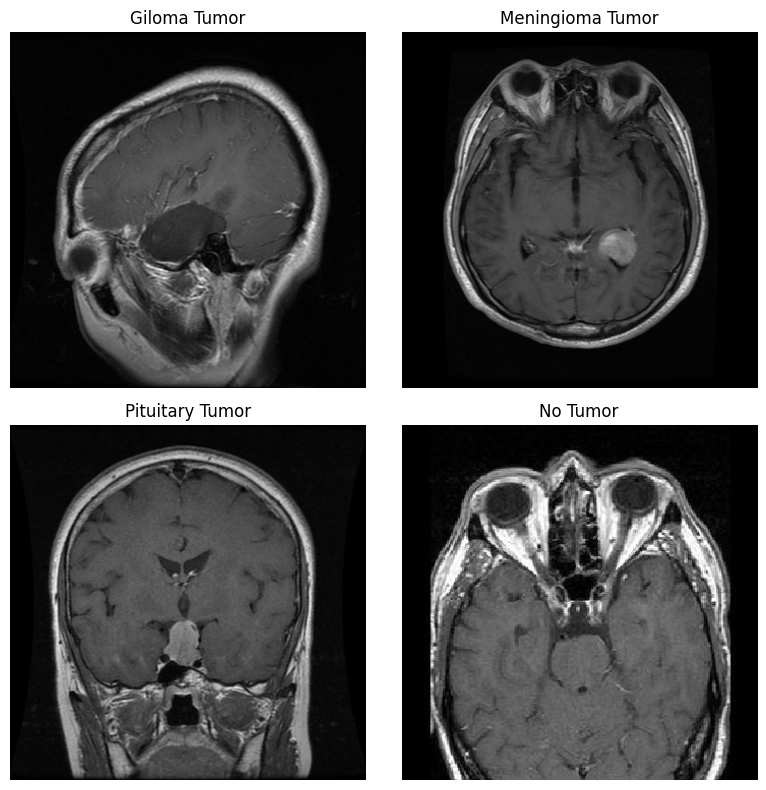

In [ ]:
# Get images
img = cv2.imread(os.path.join(train_dir + '/glioma_tumor', os.listdir(train_dir + '/glioma_tumor')[0]), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(train_dir + '/meningioma_tumor', os.listdir(train_dir + '/meningioma_tumor')[0]), cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(os.path.join(train_dir + '/pituitary_tumor', os.listdir(train_dir + '/pituitary_tumor')[0]), cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread(os.path.join(train_dir + '/no_tumor', os.listdir(train_dir + '/no_tumor')[0]), cv2.IMREAD_GRAYSCALE)


# Convert the data type to a floating-point array
img_float = img.astype('float') / 255.0
img_float_2 = img2.astype('float') / 255.0
img_float_3 = img3.astype('float') / 255.0
img_float_4 = img4.astype('float') / 255.0



fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# Plot the first image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Giloma Tumor')

# Plot the second image
axs[0, 1].imshow(img_float_2, cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].set_title('Meningioma Tumor')

# Plot the third image
axs[1, 0].imshow(img_float_3, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Pituitary Tumor')

# Plot the fourth image
axs[1, 1].imshow(img_float_4, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('No Tumor')

# Display the plot
plt.tight_layout()
plt.show()

Una vez presentada una primera visualización de como son las imágenes. Se muestra la distribución tanto en el conjunto de entrenamiento como de prueba. Estos conjuntos describen una distribución aproximada del 80% - 20% con respecto al conjunto de datos original.

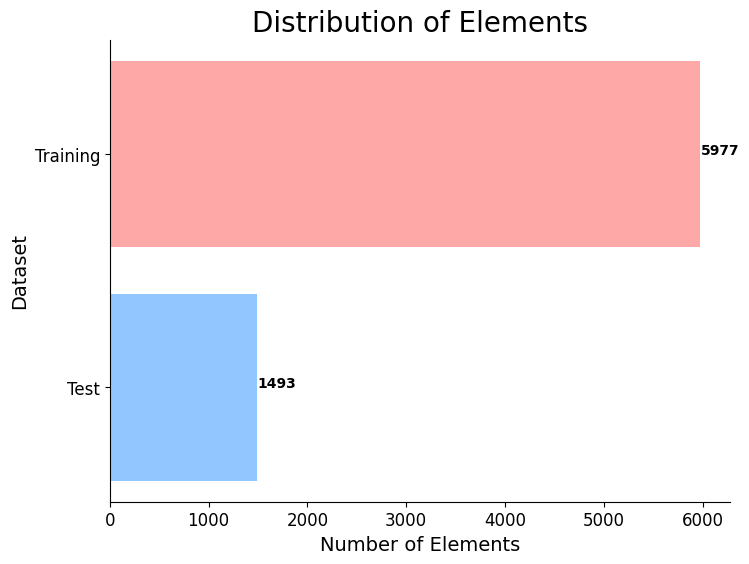

In [ ]:

# Count the number of elements in each directory
test_count = sum([len(files) for r, d, files in os.walk(test_dir)])
train_count = sum([len(files) for r, d, files in os.walk(train_dir)])

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(['Test', 'Training'], [test_count, train_count], color=['#92c6ff', '#ffa8a8'])

# Add text labels to the bars
for i, v in enumerate([test_count, train_count]):
    ax.text(v + 3, i, str(v), color='black', fontweight='bold')

# Customize the plot
ax.set_title('Distribution of Elements', fontsize=20)
ax.set_xlabel('Number of Elements', fontsize=14)
ax.set_ylabel('Dataset', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.show()

* A continuación, se profundiza en la distribución de cada clase dentro de los conjuntos de entrenamiento y test. 
* Como se puede ver en los respectivos gráficos de barras, las clases están prácticamente balanceadas. Cabe destacar que la clase **glioma tumor** es la mas predominante en ambos conjuntos.

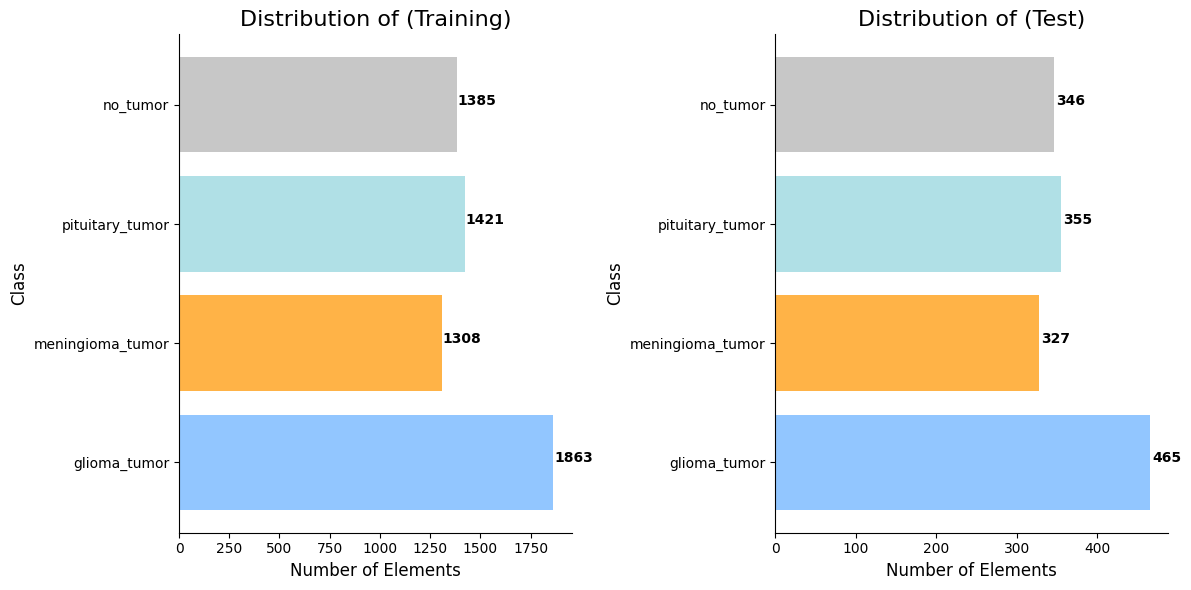

In [ ]:
# Count the number of elements in each subdirectory for both training and test directories
train_counts = []
train_subdirs = [subdir for subdir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, subdir))]
for subdir in train_subdirs:
    count = len(os.listdir(os.path.join(train_dir, subdir)))
    train_counts.append(count)

test_counts = []
test_subdirs = [subdir for subdir in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, subdir))]
for subdir in test_subdirs:
    count = len(os.listdir(os.path.join(test_dir, subdir)))
    test_counts.append(count)

# Plot the results
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Training directory plot
ax1.barh(train_subdirs, train_counts, color=['#92c6ff', '#ffb347', '#b0e0e6', '#c7c7c7'])
for i, v in enumerate(train_counts):
    ax1.text(v + 3, i, str(v), color='black', fontweight='bold')
ax1.set_title('Distribution of (Training)', fontsize=16)
ax1.set_xlabel('Number of Elements', fontsize=12)
ax1.set_ylabel('Class', fontsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

# Test directory plot
ax2.barh(test_subdirs, test_counts, color=['#92c6ff', '#ffb347', '#b0e0e6', '#c7c7c7'])
for i, v in enumerate(test_counts):
    ax2.text(v + 3, i, str(v), color='black', fontweight='bold')
ax2.set_title('Distribution of (Test)', fontsize=16)
ax2.set_xlabel('Number of Elements', fontsize=12)
ax2.set_ylabel('Class', fontsize=12)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)

fig.tight_layout()
plt.show()

* Por ultimo se muestra las características principales (largo, ancho, brillo, contraste y nitidez) de como es una imagen del conjunto de datos. Aunque se muestre una imagen particular, el resto se mueve en unos valores parecidos.

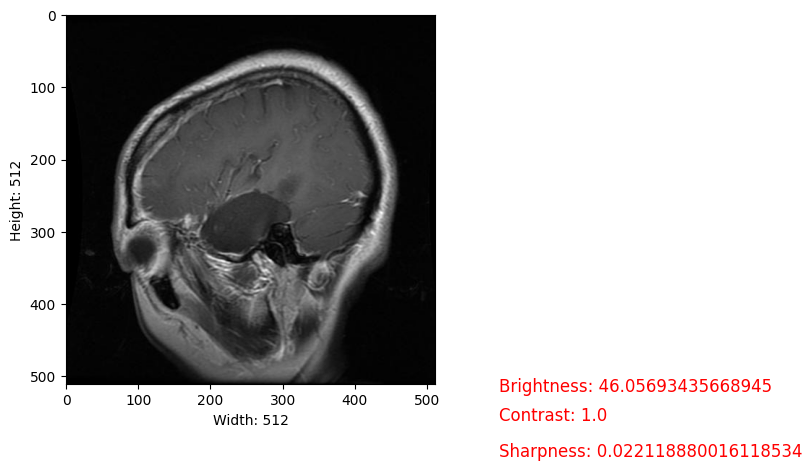

In [ ]:
# Calculate the brightness
brightness = cv2.mean(img)[0]



# Calculate the contrast
min_gray = img.min()
max_gray = img.max()
contrast = (max_gray - min_gray) / max_gray



# Calculate the sharpness
edges = filters.sobel(img)
sharpness = edges.mean()



# Get the dimensions of the image
height, width = img.shape

# Show the image and its dimensions
plt.imshow(img, cmap = 'gray')
plt.xlabel("Width: {}".format(width))
plt.ylabel("Height: {}".format(height))

# Display the properties
plt.text(600, height + 10, f"Brightness: {brightness}", fontsize=12, color='red')
plt.text(600, height + 50, f"Contrast: {contrast}", fontsize=12, color='red')
plt.text(600, height + 100, f"Sharpness: {sharpness}", fontsize=12, color='red')

plt.show()



## DATA AUGMENTATION

* Como se ha presentado en el EDA, la cantidad de imágenes que forman el dataset no es muy numerosa. Por ello se procedió a utilizar data augmentation con al finalidad de que el modelo aprenda de una mayor cantidad de imágenes distintas. Esta técnica se utilizó mediante la función de Keras ImageDataGenerator().
* Las técnicas de data augmentation que se utilizaron fueron:
  + **Rango de rotación**: 40 grados 
  + **width_shift_range**: rango de 0.2 en los que se modifica el ancho.
  + **height_shift_range**: rango de 0.2 en los que se modifica la altura.
  + **shear_range**: tipo de distorsión que inclina la forma de la imagen.
  + **zoom_range**: rango de ampliar o contraer la imagen.
  + **horizontal_flip y vertical_flip**: booleano que indica si se aplica tanto simetría en el eje vertical o horizontal.

* Por ultimo, se han configurados tres funciones para entrenamiento, test y validación. En ellas se especifica tanto el tamaño de la imagen, nº de clases, tipo de las clases, modo aleatorio... 
  

In [ ]:
# All images will be rescaled by 1./255

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
    )

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        color_mode = 'grayscale',
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical',
        classes = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor'], # Define order to posterior analysis
        shuffle = True,
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='categorical',
        classes = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor'],
        shuffle = True,
        subset='validation')

test_generator = train_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='categorical',
        classes = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor'],
        )

Found 4783 images belonging to 4 classes.
Found 1194 images belonging to 4 classes.
Found 1493 images belonging to 4 classes.


### ImageDataGenerator:

+ rescale: This parameter is used to rescale the pixel values of the images. The pixel values are multiplied by the scaling factor specified in this parameter. For example, if rescale=1./255, the pixel values of the images will be scaled down to the range of [0,1].

+ rotation_range: This parameter is used to rotate the images by a specified range of degrees.

+ width_shift_range and height_shift_range: These parameters are used to shift the images horizontally and vertically, respectively, by a fraction of the image's width or height.

+ shear_range: This parameter is used to apply shearing transformations to the images.

+ zoom_range: This parameter is used to apply zooming transformations to the images.

+ horizontal_flip and vertical_flip: These parameters are used to flip the images horizontally or vertically, respectively.

+ fill_mode: This parameter is used to fill in any empty pixels that may be created by the data augmentation transformations. This can be set to "nearest", "constant", "reflect", or "wrap".

+ validation_split: This parameter is used to split the dataset into training and validation sets, with the specified fraction used for validation.

+ data_format: This parameter is used to specify the order of the dimensions in the input data. This can be set to "channels_first" or "channels_last".

+ dtype: This parameter is used to specify the data type of the input data. This can be set to "float32", "float64", "int32", "uint8", or "int64".

### Flow from directory
+ directory: This parameter specifies the path to the directory that contains the image data.

+ target_size: This parameter is used to specify the size to which the images should be resized. It should be a tuple of (height, width).

+ color_mode: This parameter is used to specify the color mode of the images. It can be set to "grayscale", "rgb", or "rgba".

+ batch_size: This parameter is used to specify the size of the batches of images that will be generated.

+ class_mode: This parameter is used to specify the type of label that will be returned by the generator. It can be set to "binary", "categorical", "sparse", or "input".

+ shuffle: This parameter is used to specify whether the data should be shuffled after each epoch.

+ seed: This parameter is used to specify the seed for the random number generator used for shuffling.

+ subset: This parameter is used to specify whether to generate data for the "training" or "validation" subset of the data. It can be set to "training" or "validation".

+ interpolation: This parameter is used to specify the interpolation method to use when resizing the images. It can be set to "nearest", "bilinear", or "bicubic".

+ follow_links: This parameter is used to specify whether to follow symbolic links to subdirectories.

## MODEL

* La arquitectura del modelo es la siguiente:
  * 5 capas convolucionales 2D donde el primer argumento es el nº de filtros , el segundo el tamaño del kernel y  activation especifica la función de activación (en este caso es relu).
  * 5 capas de Max Pooling donde (2,2) especifica el tamaño de la ventana de pooling.
  * 1 capa flatten que su función es pasar los outputs a forma vectorial.
  * 1 capa DropOut del 10\%. El dropout es una técnica de regularización para reducir el overfitting durante el entrenamiento. 
  * 2 capas full-connected que se encargan de clasiicar la imagen. Destcara que en la ultima capa de utiliza una funcion softmax ya que es la mas comun en multi class classification.


* La ultima función se encarga de configurar el procesos de aprendizaje.
  * **loss**: especifica la función de perdida, en este caso es cross-entropy que es comunmente utilizada en multi class classification problem.
  * **optimizer**: especifica el algoritmo de optimización, en este caso es Adam con un learning rate del 1e-4. Adam es popular en optimización ya que mejorar la velocidad convergencía.
  * **metrics**: especifica la metrica a monitorizar durante el entrenamiento.

In [ ]:
# Create model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['acc'])
#model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Compile
In Keras, the compile() method is used to configure the model for training, by specifying the optimizer, loss function, and evaluation metrics. The compile() method takes the following parameters:

+ optimizer: This parameter specifies the optimization algorithm to be used during training. It can be a built-in optimizer such as "adam", "rmsprop", "sgd", etc. or an instance of the Optimizer class in Keras.

+ loss: This parameter specifies the loss function to be used during training. The choice of loss function depends on the problem being solved, and it should be a string identifier or a callable function.

+ metrics: This parameter specifies the evaluation metrics to be used during training and testing. These metrics are used to monitor the performance of the model and should be a list of string identifiers or callable functions.

The compile() method returns None and the model is then ready to be trained with the fit() method.

In [ ]:
# Set callbacks to fit the model

# File name, metric to look at, only save best checkpoint based on monitor, when a monitor is better, num epochs betweenCheckpoints
checkpoint = ModelCheckpoint(filepath='./checkpoints/bestModel.h5', monitor='val_loss', save_best_only=True, mode='min', period=1)

# Metric to look at, min increase to consider as improvement, num epochs to wait without improvement, when a monitor is better
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min')

# Learning rate schedule function
def schedule(epoch, lr):
    # Calculate the new learning rate for the current epoch
    # Reduces the learning rate by a factor of 10 every 10 epochs
    new_lr = lr * math.pow(0.1, math.floor((1+epoch)/10))
    return new_lr
# LearningRateScheduler callback object
lr_scheduler = LearningRateScheduler(schedule)

callbacks = [checkpoint, early_stop, lr_scheduler]

In [ ]:
# Calculate class weights (control unbalanced dataset)

class_weights = {}
for i in range(train_generator.num_classes):
    class_weights[i] = train_generator.samples / (train_generator.classes == i).sum()

In [ ]:
# Fit model
# tf.debugging.set_log_device_placement(True)
history = model.fit_generator(
      generator=train_generator,
      epochs=100, # Controlado por Early stopping
      validation_data=validation_generator,
      # validation_steps=5,
      callbacks = callbacks,
      class_weight=class_weights
      )

<ipython-input-18-06ba1e011b05>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
150/150 [==============================] - 44s 271ms/step - loss: 5.1363 - acc: 0.3320 - val_loss: 1.1433 - val_acc: 0.5159 - lr: 1.0000e-04
Epoch 2/100
150/150 [==============================] - 37s 245ms/step - loss: 4.2921 - acc: 0.5106 - val_loss: 1.0023 - val_acc: 0.5678 - lr: 1.0000e-04
Epoch 3/100
150/150 [==============================] - 40s 270ms/step - loss: 4.1415 - acc: 0.5369 - val_loss: 0.9602 - val_acc: 0.5955 - lr: 1.0000e-04
Epoch 4/100
150/150 [==============================] - 41s 271ms/step - loss: 4.0242 - acc: 0.5616 - val_loss: 0.8950 - val_acc: 0.6315 - lr: 1.0000e-04
Epoch 5/100
150/150 [==============================] - 40s 270ms/step - loss: 3.7893 - acc: 0.5904 - val_loss: 0.9234 - val_acc: 0.6055 - lr: 1.0000e-04
Epoch 6/100
150/150 [==============================] - 41s 271ms/step - loss: 3.6822 - acc: 0.6000 - val_loss: 0.8027 - val_acc: 0.6566 - lr: 1.0000e-04
Epoch 7/100
150/150 [==============================] - 36s 243ms/step - loss: 3.54

### Fit Generator

The fit_generator() method in Keras is used to train a model on data generated batch-by-batch by a Python generator function, rather than loading the entire dataset into memory. This method takes the following arguments:

+ generator: This argument is a generator function that yields a batch of data at each iteration. The generator function should return a tuple of inputs and targets.

+ steps_per_epoch: This argument specifies the number of batches to be yielded from the generator function at each epoch. This is typically calculated as the total number of samples in the dataset divided by the batch size.

+ epochs: This argument specifies the number of times the entire dataset should be passed through the model during training.

+ validation_data: This argument is a generator function that yields a batch of validation data at each epoch.

+ validation_steps: This argument specifies the number of batches to be yielded from the validation generator at each epoch.

+ callbacks: This argument is a list of Keras callback functions that are called during training. These callbacks can be used to save the model weights, monitor training progress, adjust learning rate, etc.

+ max_queue_size: This argument specifies the maximum size of the generator queue. This should

### Callbacks:

+ ModelCheckpoint: This callback is used to save the best weights of the model during training. It can be used to monitor a specific metric, such as validation accuracy, and save the weights when that metric improves.

+ EarlyStopping: This callback is used to stop the training process if the validation loss or metric does not improve for a specified number of epochs. It can be used to prevent overfitting and save time by stopping the training process early.

+ ReduceLROnPlateau: This callback is used to reduce the learning rate of the optimizer if the validation loss or metric does not improve for a specified number of epochs. It can be used to fine-tune the model and improve performance.

+ TensorBoard: This callback is used to visualize the training process in TensorBoard, a web-based tool for visualizing the TensorFlow graph and monitoring training progress.

+ CSVLogger: This callback is used to save the training and validation metrics to a CSV file during training. It can be used to track the performance of the model over time.

+ TerminateOnNaN: This callback is used to terminate the training process if any NaN (Not a Number) values are encountered during training. It can be used to prevent the model from training on corrupt data.

+ LearningRateScheduler: This callback is used to adjust the learning rate of the optimizer at specific epochs during training. It can be used to fine-tune the learning rate and improve the performance of the model.

## METRICS 

En este apartado se comenta las metricas utilizadas para evaluar el modelo.

* En primer lugar, se presenta los graficos de linea que representan el acurracy y la perdida tanto en el conjunto de entrenamiento (rojo) como en el de test (azul).
* Como se puede observar en ambos gráficos, en el conjunto de test se obtienen mejores resultados. La curva de acurracy en test siempre se situa por encima de la de training. Por otro lado, en loss la curva de test esta por debajo de training que indica un mejor comportamiento.

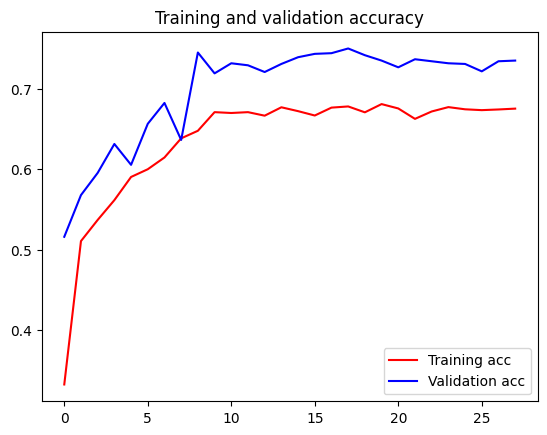

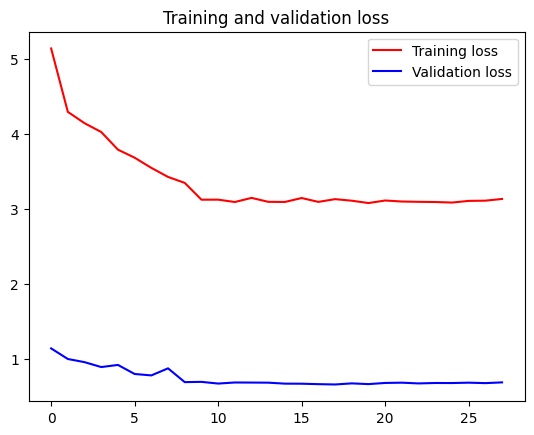

In [ ]:
# Plot results

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r-', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Load best model

best_model = load_model('./checkpoints/bestModel.h5')

In [ ]:
# Evaluate generators
train_loss, train_acc = best_model.evaluate(train_generator, steps=len(train_generator))
print('Train accuracy:', train_acc)

test_loss, test_acc = best_model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

150/150 [==============================] - 29s 192ms/step - loss: 0.7813 - acc: 0.6764
Train accuracy: 0.6763537526130676
47/47 [==============================] - 9s 199ms/step - loss: 0.7747 - acc: 0.6852
Test accuracy: 0.6851975917816162


In [ ]:
# Predictions

# New generators  without shuffle

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='categorical',
        classes = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor'], # Define order to posterior analysis
        shuffle = False)

test_generator = train_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        color_mode = 'grayscale',
        batch_size=32,
        class_mode='categorical',
        classes = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor'],
        shuffle = False)

# Train
train_pred = best_model.predict(train_generator, steps=len(train_generator))
train_pred = np.argmax(train_pred, axis=-1)
train_classes = train_generator.classes

# Test
test_pred = best_model.predict(test_generator, steps=len(test_generator))
test_pred = np.argmax(test_pred, axis=1)
test_classes = test_generator.classes

Found 5977 images belonging to 4 classes.
Found 1493 images belonging to 4 classes.
47/47 [==============================] - 9s 197ms/step


In [ ]:
# Evaluate generator

classes = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']

# Confusion matrix
# Create confusion matrix for train set
train_cm = confusion_matrix(train_classes, train_pred)
print('Train CM:')
print(train_cm)
# Create confusion matrix for test set
test_cm = confusion_matrix(test_classes, test_pred)
print('Test CM:')
print(test_cm)

# Metrics
# Train
train_accuracy = accuracy_score(train_classes, train_pred)
train_precision = precision_score(train_classes, train_pred, average=None)
train_recall = recall_score(train_classes, train_pred, average=None)
train_f1 = f1_score(train_classes, train_pred, average=None)
print("Train accuracy:", train_accuracy)
print("Train precision:", train_precision)
print("Train recall:", train_recall)
print("Train F1 score:", train_f1)
# Test
test_accuracy = accuracy_score(test_classes, test_pred)
test_precision = precision_score(test_classes, test_pred, average=None)
test_recall = recall_score(test_classes, test_pred, average=None)
test_f1 = f1_score(test_classes, test_pred, average=None)
print("Test accuracy:", test_accuracy)
print("Test precision:", test_precision)
print("Test recall:", test_recall)
print("Test F1 score:", test_f1)

Train CM:
[[1326   40    1   18]
 [ 170 1241    2    8]
 [ 669  579  380  235]
 [ 367  506   25  410]]
Test CM:
[[324  12   0  10]
 [ 44 308   2   1]
 [191 146  76  52]
 [ 95 108   5 119]]
Train accuracy: 0.5616530031788523
Train precision: [0.52369668 0.52451395 0.93137255 0.61102832]
Train recall: [0.95740072 0.87332864 0.20397209 0.31345566]
Train F1 score: [0.67704876 0.65540005 0.33465434 0.41435068]
Test accuracy: 0.5539182853315472
Test precision: [0.49541284 0.53658537 0.91566265 0.65384615]
Test recall: [0.93641618 0.86760563 0.16344086 0.36391437]
Test F1 score: [0.648      0.66307858 0.27737226 0.4675835 ]


### Forma mas ordenadita

En esta parte se evalua tanto la confusion matrix (CM) como una serie de metricas relevantes para medir el rendimiento del modelo.

* En la CM que se presenta se han utilizado los datos de test. En ella cabe destacar:
  * Tanto *no_tumor* como *pituitary_tumor* el modelo los identifica bastante bien. 
  * Respecto a *meningioma_tumor* lo confunde mayoritariamente con *pituitary_tumor*
  * El *glioma_tumor* es el que más le cuesta ya que lo confunde con *no_tumor* y *pituitary_tumor*

* Ahora se analiza como se comporta el modelo para cada clase

  * **NO_tumor**: con una precision del 0.5 indica la certeza del modelo en los casos de *no_tumor* que han sido predichos como tales (indica una alta tasa de falsos positivos). Respecto a un recall del 0.94, se tiene que el modelo identifica un 94% de los casos que son realmente de esta clase. Con todo ello se obtiene un F1 score de 0.65, donde se observa cierto desbalanceo entre precision y recall. En resumen, el modelo tiene un buen rendimiento en esta clase aunque la precisión se podria aumentar para reducir la tasa de falsos positivos. 

  * **Pituitary_tumor**: con una precision del 54% indica una alta tasa de falsos positivos. Respecto al recall se tiene un 87% indetificados correctamente, con todo ello se obtiene un f1 score de 0.66. En resumen, se puede decir que el modelo tiene un rendiemiento decente pero se puede mejorar la tasa de falsos negativos, al igual que en el caso anterior.

  * **Glioma tumor**: En este caso la precision es de un 0.92 i.e. de todos los que se predicieron como positivos el 92% lo eran realmente. Por otro lado, el recall es de 0.16 por lo que de todos los tumores de esta clase en el dataset solo se identifica un 16%. Todo ello hace que se obtenga un F1 score de 0.28. En conclusión, el modelo tiende a ser certero a la hora de clasificar correctamente los gliomas aunque no a identificarlos. El F1 score indica que el rendiemiento puede mejorarse, aunque al tener una alta precision puede ser bastante util en algunos casos.

  * **Meningioma_tumor**: En este caso la precision es de 0.65 y con un recall del 0.36 lo que implica un F1 score del 0.47. Esto inidica un mal balance entre recall y precisión. Con todo ello, se puede decir que el modelo no es muy bueno etectando este tipo de tumor, como vimos en la matriz de confusión, era uno de los que confundía.

En función del problema podríamos escoger el mejor modelo según distintas métricas, en este caso, el peor escenario es contar con falsos negativos en la clase no_tumor, por ello la métrica a elegir sería una precisión alta en dicha clase, a pesar de sacrificar cierto recall (se pueden realizar analíticas posteriores). Por el mismo motivo, en el resto de clases priorizaríamos el recall.   

47/47 [==============================] - 9s 193ms/step - loss: 1.0831 - acc: 0.5539
Test loss: 1.0831, Test accuracy: 0.5539
47/47 [==============================] - 7s 136ms/step


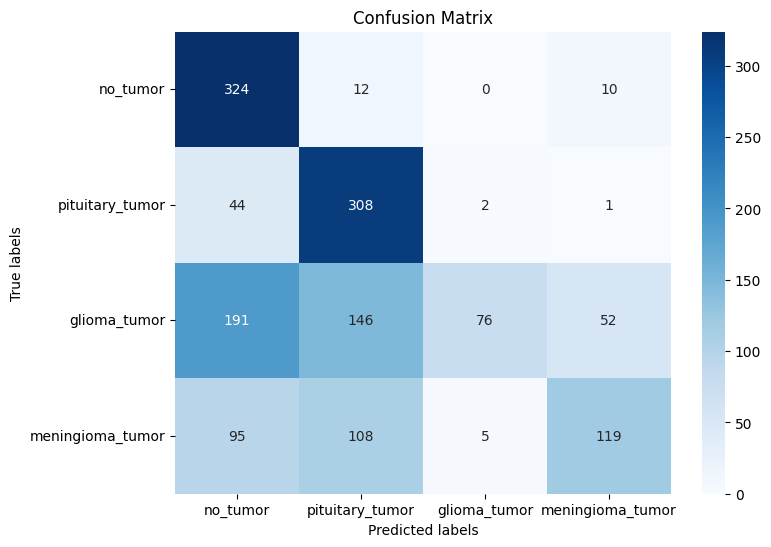

                  precision    recall  f1-score   support

        no_tumor       0.50      0.94      0.65       346
 pituitary_tumor       0.54      0.87      0.66       355
    glioma_tumor       0.92      0.16      0.28       465
meningioma_tumor       0.65      0.36      0.47       327

        accuracy                           0.55      1493
       macro avg       0.65      0.58      0.51      1493
    weighted avg       0.67      0.55      0.50      1493



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Define class names
class_names = ['no_tumor', 'pituitary_tumor', 'glioma_tumor', 'meningioma_tumor']

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

# Make predictions on test set
test_preds = model.predict(test_generator)

# Get predicted class indices
test_pred_classes = np.argmax(test_preds, axis=1)

# Get true class indices
test_true_classes = test_generator.classes

# Generate confusion matrix
confusion_mtx = confusion_matrix(test_true_classes, test_pred_classes)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_mtx, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_true_classes, test_pred_classes, target_names=class_names))


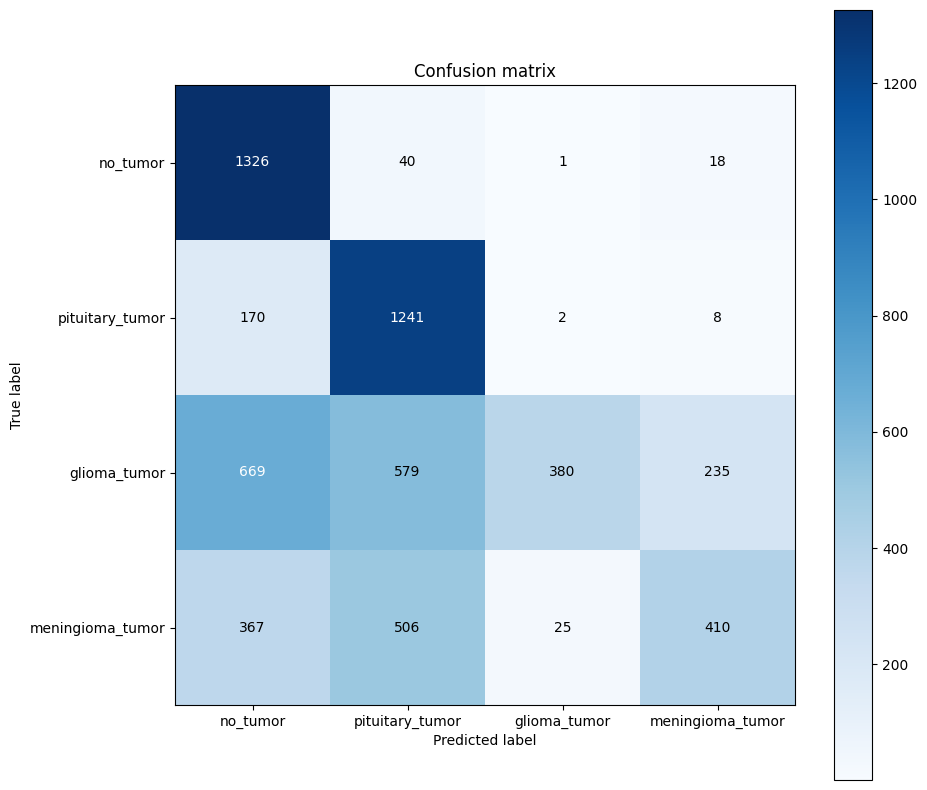

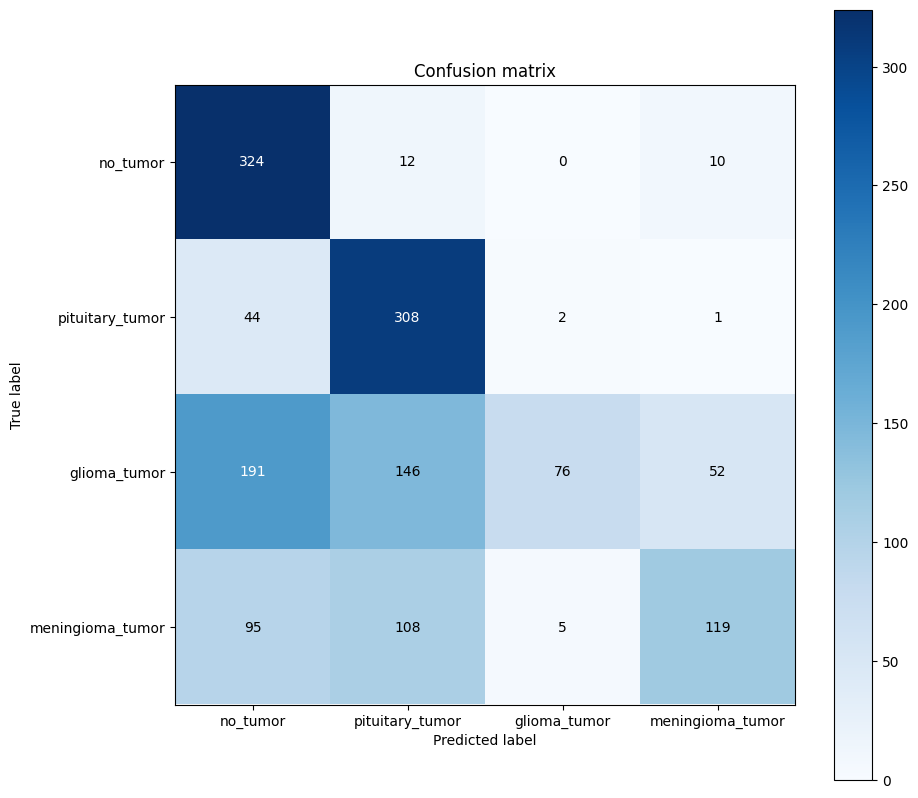

In [ ]:
# Plot Train CM
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(train_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(train_cm.shape[1]),
       yticks=np.arange(train_cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add labels to the plot
thresh = train_cm.max() / 2.
for i in range(train_cm.shape[0]):
    for j in range(train_cm.shape[1]):
        ax.text(j, i, format(train_cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if train_cm[i, j] > thresh else "black")

# Add a color bar to the plot
plt.colorbar(im)

# Display the plot
plt.show()

# Plot Test CM
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set(xticks=np.arange(test_cm.shape[1]),
       yticks=np.arange(test_cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add labels to the plot
thresh = test_cm.max() / 2.
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, format(test_cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if test_cm[i, j] > thresh else "black")

# Add a color bar to the plot
plt.colorbar(im)

# Display the plot
plt.show()

## HUMAN BENCHMARKS

En esta breve sección vamos a comentar dos estudios que hablan sobre la eficacia de los especialistas en la detección de tumores a través de MRI.



* El primer estudio se publicó en *the Journal of Neuro-Oncology* en 2016. En él se evaluaba sensitivity and specificity  (habilidad de detectar casos positivos y negativos, respectivamente) de los radiólogos en la detección de tumores cerebrales en MRI. El estudio aportó un 83÷% specificity y un 88% en sensitivity. [1]


* El segundo estudio la precisión de los radiólogos es más baja que en el primero. En este caso, sensitivity fue de un 75\%. Hay que destacar que en este articulo se utilizo una muestra muy reducida tanto de imágenes como de especialistas en comparación con el primero.[2]

[1] Hwang, E.J., Park, C.K., Kang, S.H., Kim, J.H., Kim, H.S., Kim, I.A., Kim, Y.H., Kim, S.T., Jung, T.Y. and Moon, K.S., 2016. Interobserver variability in the interpretation of magnetic resonance images of glioma according to the revised brain tumor classification system. Journal of neuro-oncology, 129(1), pp.167-174.

[2] Herrmann, K. A., Laudadio, J., Yung, K. C., Yi, J., Lopes, V., Hsu, W., & Kuo, M. D. (2018). Accuracy of radiologists in determining the presence of brain tumor using MRI: Inter- and intra-rater reliability and comparison with surgeons and pathologists. Journal of Medical Imaging and Radiation Oncology, 62(1), 44-49.

Aumentando el tamaño de la red y la calidad y cantidad de datos sería asumible alcanzar dichas métricas.